#### Minimum vertex cover
Find a subset of the vertices of the graph such that for each edges ( connected by two vertices a,b ) either of the edges ( a or b ) is in the subset. 

$ min (y) = \sum_{i} x_i $

The constraint is that we need to minimize the presence of either of the vertices of a edge with a penalty. 

$ min (y) = \sum_{i} x_i + P(\sum_{i,j \in E} (1 - x_i - x_j + x_i.x_j)) $

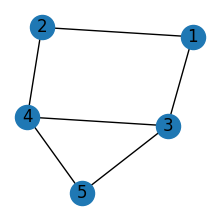

In [127]:
import networkx as nx 
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(2, 2))

G = nx.Graph()

nodes = [1,2,3,4,5]
edges = [(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)]

linear = [0]*len(nodes)

G.add_nodes_from(nodes)
for s,e in edges:
    G.add_edge(s,e)
    linear[s-1]+=1
    linear[e-1]+=1

nx.draw(G, with_labels=True)

For the above graph, the minimize function would be as below. 

$ minimize (y) = x_1 + x_2 + x_3 + x_4 + x_5 + P(\sum_{i,j \in E} (1 - x_i - x_j + x_i.x_j)) $

E = [[1,3],[1,2],[2,4],[3,4],[3,5],[4,5]]

$ minimize (y) = x_1 + x_2 + x_3 + x_4 + x_5 \\
    \quad + P(1 - x_4 - x_5 + x_4.x_5) \\
    \quad + P(1 - x_3 - x_5 + x_3.x_5) \\
    \quad + P(1 - x_3 - x_4 + x_3.x_4) \\
    \quad + P(1 - x_2 - x_4 + x_2.x_4) \\
    \quad + P(1 - x_1 - x_3 + x_1.x_3) \\
    \quad + P(1 - x_1 - x_2 + x_1.x_2) $


Arbitrarility choose P = 50. 

$ minimize (y) = 6.P + (1-2P).x_1 + (1-2P).x_2 + (1-3P).x_3 + (1-3P).x_4 + (1-2P).x_5 + \\ 
    \quad Px_1.x_2 + Px_1.x_3 + Px_2.x_4 + Px_3.x_4 + Px_3.x_5 + Px_4.x_5 $  

$ minimize (y) = 300 + -99.x_1 + -99.x_2 + -149.x_3 + -149.x_4 + -99.x_5 + \\ 
    \quad 50.x_1.x_2 + 50.x_1.x_3 + 50.x_2.x_4 + 50.x_3.x_4 + 50.x_3.x_5 + 50.x_4.x_5 $  


In [128]:
from qiskit_optimization import QuadraticProgram
from qiskit import BasicAer
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance
from qiskit.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA

In [129]:
mod = QuadraticProgram()
[mod.binary_var("x"+str(i+1)) for i in range(len(nodes))]

cnt = 1
for s,e in edges:
    linear_constraints = {}
    linear_constraints["x"+str(s)] = 1
    linear_constraints["x"+str(e)] = 1
    
    mod.linear_constraint(linear=linear_constraints, sense=">=", rhs=1, name="lin_eq" + str(cnt))
    cnt += 1

mod.minimize(quadratic={
    ("x1", "x1"):-99, 
    ("x2", "x2"):-99, 
    ("x3", "x3"):-149, 
    ("x4", "x4"):-149, 
    ("x5", "x5"):-99,

    ("x1", "x2"):50,
    ("x1", "x3"):50,
    ("x2", "x4"):50,
    ("x3", "x4"):50,
    ("x3", "x5"):50,
    ("x4", "x5"):50,
})

print (mod.prettyprint())  

Problem name: 

Minimize
  -99*x1^2 + 50*x1*x2 + 50*x1*x3 - 99*x2^2 + 50*x2*x4 - 149*x3^2 + 50*x3*x4
  + 50*x3*x5 - 149*x4^2 + 50*x4*x5 - 99*x5^2

Subject to
  Linear constraints (6)
    x1 + x2 >= 1  'lin_eq1'
    x1 + x3 >= 1  'lin_eq2'
    x2 + x4 >= 1  'lin_eq3'
    x3 + x4 >= 1  'lin_eq4'
    x3 + x5 >= 1  'lin_eq5'
    x4 + x5 >= 1  'lin_eq6'

  Binary variables (5)
    x1 x2 x3 x4 x5



In [130]:
quantum_instance = Sampler()
qaoa_mes = QAOA(quantum_instance, COBYLA(), reps=2)
qaoa = MinimumEigenOptimizer(qaoa_mes)

qaoa_result = qaoa.solve(mod)
[qaoa_result.x], [300+qaoa_result.fval]


([array([1., 0., 1., 1., 0.])], [3.0])